# Deutsch-Jozsa Algorithm
<hr></hr>

Deutsch's algorithm (named after [David Deutsch](https://en.wikipedia.org/wiki/David_Deutsch)) was the first demonstration of how quantum computing provides an advantage over classical computational methods [[Deutsch85](https://www.cs.princeton.edu/courses/archive/fall06/cos576/papers/deutsch85.pdf)]. The algorithm was later generalized for more than one qubit by David Deutsch and Ricahrd Jozsa [[Deutsch92](https://royalsocietypublishing.org/doi/abs/10.1098/rspa.1992.0167)], in what is today known as the [Deutsch-Jozsa algorithm](https://en.wikipedia.org/wiki/Deutsch%E2%80%93Jozsa_algorithm).

Even though these two algorithms do not solve problems of practical relevance, they are of indisputable historical importance, and laid the foundation for the development of all other quantum algorithms known today.

## 1. Deutsch's Algorithm

The formulation of the popularized version of Deutsch's algorithm was first presented by Richard Cleve, et. al. in 1997 [[Cleve97](https://arxiv.org/abs/quant-ph/9708016)]. It differs from Deutsch's original proposal in that it **deterministically** provides the right solution to what is known as Deutsch's problem in a single try. On the other hand, a classical strategy can only provide the right answer 50% of the time by taking a random guess, or takes two tries to guarantee getting the right answer.

We will start by describing of how the algorithm works by casting it as a guessing game, followed by a formal definition in terms of the [quantum function evaluation](https://learnquantum.io/chapters/02_quantum_computing/02_05_quantum_blocks.html#quantum-function-evaluation) strategy we previously discussed.

### 1.1 General Overview

A relatively intuitive way to understand Deutsch's problem is by setting it up in the form of a game. 

Imagine you are presented with a black box with two inputs and two outputs.

<img src="images/04_01_01_black_box.png" align = "center" width="200"/>

The box is "black" because you can't see what's inside; however, you are told that, with certainty, the box corresponds to one of four possible reversible circuits:

<img src="images/04_01_02_oracles.png" align = "center" width="750"/>

1. The first circuit is simple, both inputs go straight to the output.

2. The second circuit is similar, except the bottom input is always negated.

3. In the third circuit, the bottom output gets negated _if_ the top input is 1.

4. In the fourth circuit, the bottom output gets negated _if_ the top input is 0.

There are then two types of circuits: 

$\text{I}$. Those where the top and bottom paths are independent of each other (circuits 1 and 2),

$\text{II}$. Those where the top input can "influence" the bottom output (circuits 3 and 4).

To win the game, you have to correctly guess which type of circuit is inside the box (either type $\text{I}$ or type $\text{II}$).

#### 1.1.1 Classical Strategy 

A first naïve strategy is to check if there is a combination of classical input values $x, y \in \{0, 1\}$ that provide different outputs for each of the two types of circuits. Now, since in all four circuits the top output is just a direct copy of a classical input $|x\rangle$, its value gives us no information about what's inside the box. We then only need to focus on what happens to the bottom output. Furthermore, given that the objective is to find if we have a box where the top path controls the bottom path (or not), the value that $y$ takes is irrelevant, so we can set it to $0$. We can then represent our black-box problem in terms of a single input $|x\rangle$ and a single output $|f(x)\rangle$:

<img src="images/04_01_03_black_box_simp.png" align = "center" width="270"/>

where we have a different $f(x)$ for each of the four possible circuits:

1. $f_1(x) = 0$. The output $|f(x)\rangle$ is always $|0\rangle,$ regardless of the value of the input $|x\rangle;$.

2. $f_2(x) = 1$. The output $|f(x)\rangle$ is always $|1\rangle,$ regardless of the value of the input $|x\rangle;$.

3. $f_3(x) = x$. The output $|f(x)\rangle$ is equal to $|x\rangle;$ i.e., is the same value as the top input.

4. $f_4(x) = \bar{x}$. The output $|f(x)\rangle$ is equal to $|\bar{x}\rangle;$ i.e., the opposite value of the top input.

We can also summarize these four functions using Boolean tables:

<div style="display: flex; flex-wrap: wrap; gap: 20px;">

<div style="flex: 1;">

| $x$ | $f_1(x)$ |
| :-: |    :-:   |
| $0$ |    $0$   |
| $1$ |    $0$   |

    
</div>

<div style="flex: 1;">

| $x$ | $f_2(x)$ |
| :-: |    :-:   |
| $0$ |    $1$   |
| $1$ |    $1$   |
    
</div>

<div style="flex: 1;">

| $x$ | $f_3(x)$ |
| :-: |    :-:   |
| $0$ |    $0$   |
| $1$ |    $1$   |
    
</div>

<div style="flex: 1;">

| $x$ | $f_4(x)$ |
| :-: |    :-:   |
| $0$ |    $1$   |
| $1$ |    $0$   |
    
</div>

</div>

Given that, independent of the input value, circuit 1 always provides a $0$ and circuit 2 always generates a $1$, we call these circuits (and their respective functions) <span style="color:#a883f7">**constant**</span>. On the other hand, since circuits 3 and 4 generate both possible outputs ($0$ and $1$) depending on the input value, we call them <span style="color:#a883f7">**balanced**</span>. So our guessing game basically consists of figuring out if we have a constant or a balanced circuit.

Now, here is the culprit. Since we only get one chance at guessing which box we have, it is impossible for us to come up with a classical strategy to always win in one try. If we were to set our input to $|0\rangle$, we wouldn't be able to differentiate circuit 1 from circuit 3 because they both give an output of $|0\rangle$, or circuit 2 from circuit 4 because they both give an output of $|1\rangle$. Similarly, if we were to set our input to $|1\rangle$, we would not be able to tell circuit 1 and circuit 4 apart because they both give an output of $|0\rangle$, or circuit 2 from circuit 3 because they both give an output of $|1\rangle$. Therefore, our probability of winning using this classical strategy in one try is of only $50 \%$ (assuming we are given either a constant or balanced circuit with equal probability).

Let's simulate this by creating a function that generates a random black box, then taking a guess at which circuit we have based on the output, and checking the percentage of times we're right/wrong.

In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator

In [2]:
# Function that generates at random (with equal probability) each of the four possible circuits
def black_box():
    
    bb_num = np.random.randint(1,3) # Choose one of four possible black-box circuits
    
    qc_bb = QuantumCircuit(2, name='Black Box')
    match bb_num:
        case 1:                               # Option 1: Leave circuit empty
            pass           
        case 2:                               # Option 2: Add X gate to bottom qubit
            qc_bb.x(0)
        case 3:                               # Option 3: Add CX gate between top and bottom qubits
            qc_bb.cx(1,0,ctrl_state='1')
        case 4:                               # Option 4: Add C̅X gate between top and bottom qubits
            qc_bb.cx(1,0,ctrl_state='0')
            
    return qc_bb, bb_num                      # return black-box and corresponding number

In [3]:
# Implement circuit to solve Deutsch's problem classically
# Takes input value x and generates circuit with random black box and output meas
def deutsch_classic(x=0):
    bb, bb_num = black_box()  # generate random black-box
    
    qc_dc = QuantumCircuit(2,1)
    if x: qc_dc.x(1)             # if x = 1, add X gate to top qubit
    qc_dc.append(bb,[0,1])       # append black box to circuit
    qc_dc.measure(0,0)           # measure bottom qubit
    
    return qc_dc, bb_num

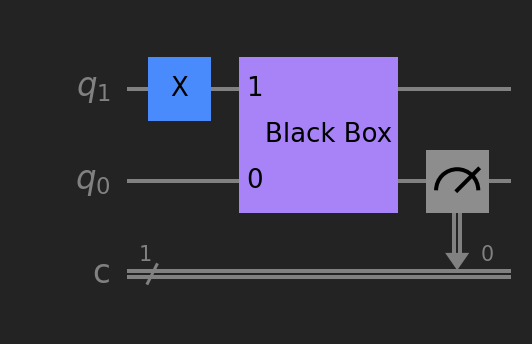

In [4]:
# Draw circuit to solve Deutsch's problem classically (input x = 1)
deutsch_classic(x=1)[0].draw()

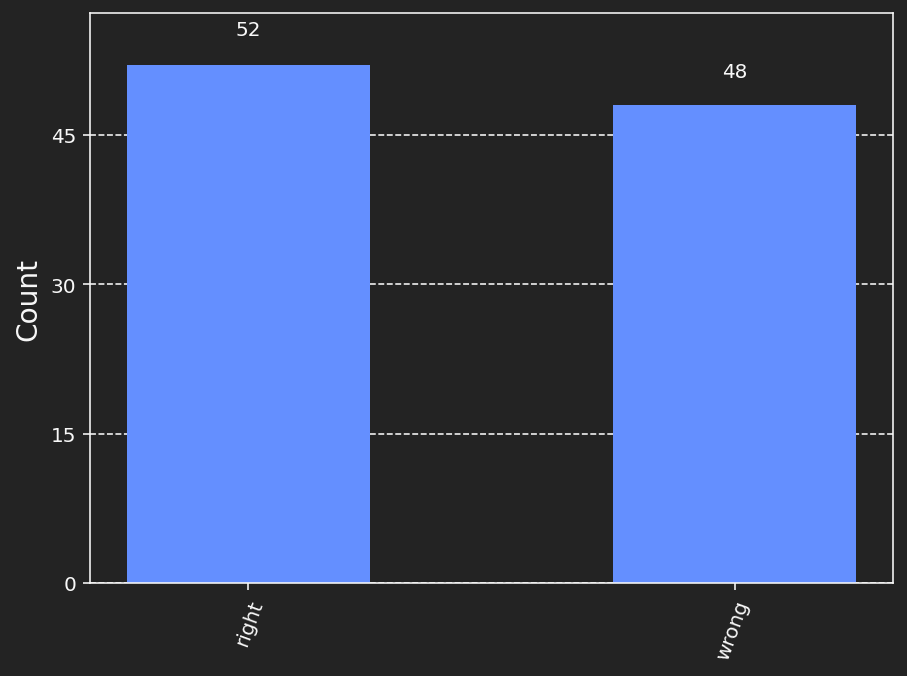

In [5]:
x = 1                            # Value of input x (can be 0 or 1)
k = 100                          # Number of times to play the game
guesses = {'right':0,'wrong':0}  # list of right/wrong guesses

simulator = AerSimulator()       # define simulator object

for i in range(k):
    qc, bb_num = deutsch_classic(x)
    
    qc_t = transpile(qc, simulator)
    job = simulator.run(qc_t, shots=1, memory=True)  # Run one simulation per black box 
                                                     # (we're only allowed to guess once)

    fx = job.result().get_memory()[0]        # extract output value of f(x)
     
    if (x == 0) and (fx == '0'):             # if x=0 and f(x)=0 we have either cir 1 or cir 3
        guess = np.random.choice([1,3])      # take random guess between circuit 1 or 3 (const or bal)
    
    elif (x == 0) and (fx == '1'):           # if x=0 and f(x)=1 we have either cir 2 or cir 4
        guess = np.random.choice([2,4])      # take random guess between circuit 2 or 4 (const or bal)
    
    elif (x == 1) and (fx == '0'):           # if x=1 and f(x)=0 we have either cir 1 or cir 4
        guess = np.random.choice([1,4])      # take random guess between circuit 1 or 4 (const or bal)
        
    elif (x == 1) and (fx == '1'):           # if x=1 and f(x)=1 we have either cir 2 or cir 3
        guess = np.random.choice([2,3])      # take random guess between circuit 2 or 3 (const or bal)
        
        
    if guess == bb_num:
        guesses['right'] += 1
    else:
        guesses['wrong'] += 1
        
plot_histogram(guesses)

As can be seen, we are equally likely to guess having the right type of circuit (constant or balanced) using this classical strategy. What Deutsch's algorithm enables, is the ability to **always** get the right answer in one try. But for this, we need to allow our inputs and outputs to the black to take quantum values (superposition states) rather than only being $|0\rangle$ or $|1\rangle$.

#### 1.1.2 Quantum Strategy

As mentioned before, Deutsch's problem can be summarized as trying to find if the circuit inside a black box is <span style="color:#a883f7">**constant**</span> (which results when the top and bottom qubit are independent), or <span style="color:#a883f7">**balanced**</span> (which occurs when the top qubit can affect the outcome of the bottom qubit). Deutsch's algorithm exploits the fact that we can effectively construct a quantum circuit around our black box that deterministically changes the output state of the **top** qubit based on having a controlled gate inside the box. To understand how this is possible, let's compare circuits 1 and 3, both of which were indistinguishable in our classical approach when the input was $x = 0$. If we were to add Hadamard gates before and after our black box as follows: 

<img src="images/04_01_04_black_box_hadamard.png" align = "center" width="300"/>

we get the following equivalency for circuit 1:

<img src="images/04_01_05_cir1_equiv.png" align = "center" width="630"/>

and the following for circuit 3:

<img src="images/04_01_06_cir3_equiv.png" align = "center" width="630"/>

The result for circuit 1 is simple to explain: since the Hadamard gate is its own conjugate transpose (i.e., it is [Hermitian](https://en.wikipedia.org/wiki/Hermitian_matrix)), applying two Hadamard gates back to back to a qubit results in the identity operation (as we [pointed out](https://learnquantum.io/chapters/02_quantum_computing/02_03_single_qb_sys.html#refining-quantum-gates) before). In other words, the operation of circuit 1 is unmodified when adding the Hadamard gates.

As for the result for circuit 3, this is exactly what we [previously observed](https://learnquantum.io/chapters/02_quantum_computing/02_05_quantum_blocks.html#kickback-in-action) for the phase-kickback effect acting on an $X$ gate! Applying Hadamard gates before and after a $CX$ gate swaps its control direction.

Thus, if we now initialize the top qubit in state $|0\rangle$ and the bottom qubit in state $|1\rangle$, we are guaranteed to have the top output qubit in state $|0\rangle$ for circuit 1, and in state $|1\rangle$ for circuit 3, making them now distinguishable from one another. A similar analysis can be carried out for circuits 2 and 4, which again allows us to differentiate them (we will go over this step by step in the next section).

So, in summary, by wrapping our black box with Hadamard gates, we are able to distinguish a **constant** circuit from a **balanced** circuit by measuring the top qubit, and checking if the result was $|0\rangle$ or $|1\rangle$, respectively.

Let us now perform a simulation similar to that of the classical strategy and compare the times we guess if we correctly identify if the circuit we have is constant or balanced.

In [6]:
# Implement circuit to solve Deutsch's problem using Deutsch's algorithm
def deutsch_quantum():
    bb, bb_num = black_box()  # generate random black-box
    
    qc_dq = QuantumCircuit(2,1)
    qc_dq.x(0)                   # Initialize bottom qubit to |1〉
    qc_dq.barrier()
    qc_dq.h([1,0])               # Hadamard before black box
    qc_dq.append(bb,[0,1])       # append black box to circuit
    qc_dq.h([1,0])               # Hadamard after black box
    qc_dq.measure(1,0)           # measure top qubit
    
    return qc_dq, bb_num

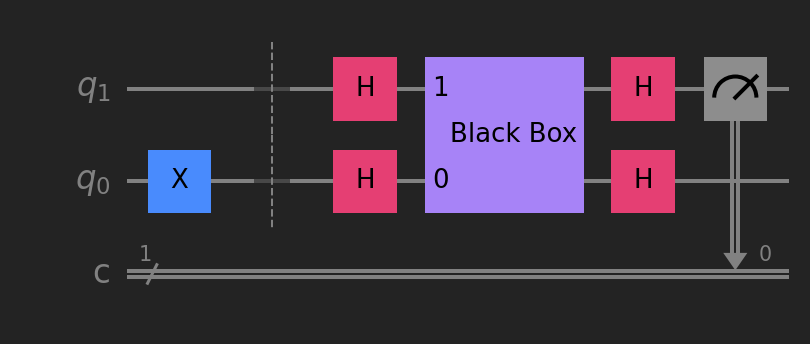

In [7]:
# Draw circuit for Deutsch's Algorithm
deutsch_quantum()[0].draw()

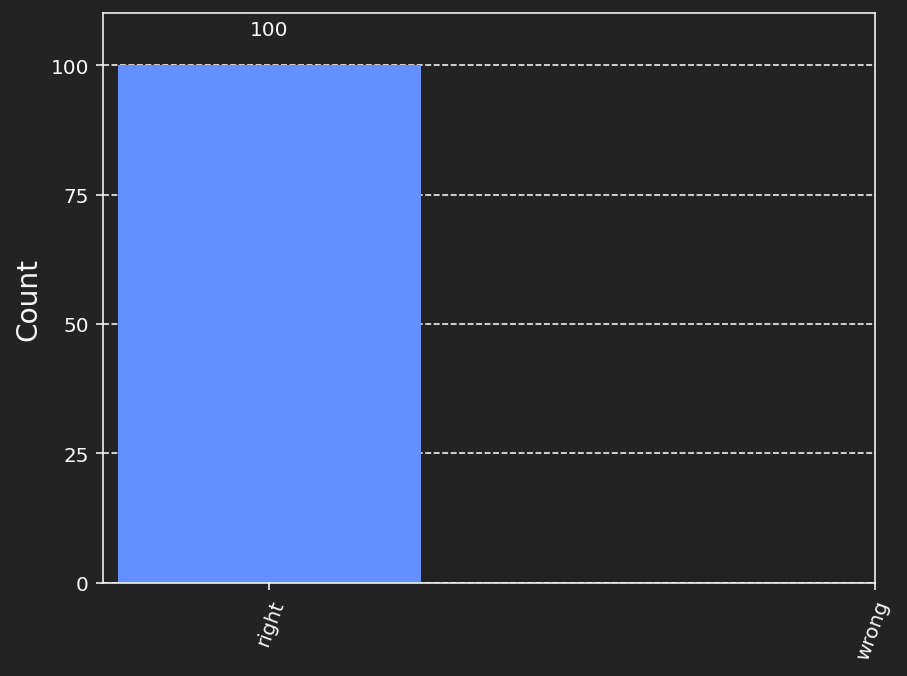

In [8]:
k = 100                           # Number of times to play the game
guesses = {'right':0,'wrong':0}   # list of right/wrong guesses

simulator = AerSimulator()        # define simulator object

for i in range(k):
    qc, bb_num = deutsch_quantum()                   # generate black box
    bb_type = 'c' if bb_num in (1, 2) else 'b'       # type of black box
    
    qc_t = transpile(qc, simulator)
    job = simulator.run(qc_t, shots=1, memory=True)  # Run one simulation per black box 
                                                     # (we're only allowed to guess once)

    top_qubit = job.result().get_memory()[0]         # extract output value of top qubit
    
    if top_qubit == '0':    # If top qubit is 0, we know circuit is constant (c)          
        guess = 'c'                    
    elif top_qubit == '1':  # If top qubit is 1, we know circuit is balanced (b)
        guess = 'b'
    
    if guess == bb_type:
        guesses['right'] += 1
    else:
        guesses['wrong'] += 1
        
plot_histogram(guesses)

As seen, Deutsch's algorithm provides a way to distinguish between the two different types of circuits (constant or balanced) in one try deterministically (i.e., without having to take a random guess).

### 1.2 Step-by-Step Description

The previous section provided a general sketch of how Deutsch's algorithm works. Let's now formalize this by analyzing the circuit step by step:

<img src="images/04_01_07_deutsch.png" align = "center" width="500"/>

0. We start with both qubits initialized in state $|0\rangle$:

$$ |\psi \rangle_0 = |0\rangle|0\rangle. $$


1. This is followed by applying an $X$ to the bottom qubit (qubit $0$):

$$ 
\begin{aligned}
|\psi \rangle_1 &= (I \otimes X)|\psi \rangle_0
\\
\\
|\psi \rangle_1 &= |0\rangle|1\rangle .
\end{aligned}
$$

2. We then apply Hadamard gates to both qubits, placing qubit $1$ and qubit $0$ in the superposition states $|+\rangle$ and $|-\rangle$, respectively:

$$ 
\begin{aligned}
|\psi \rangle_2 &= (H \otimes H)|\psi \rangle_1
\\
\\
|\psi \rangle_2 &= |+\rangle|-\rangle
\\
\\
|\psi \rangle_2 &= \frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle \right) \otimes \frac{1}{\sqrt{2}}\left(|0\rangle - |1\rangle \right)
\\
\\
|\psi \rangle_2 &= \frac{1}{2}\left(|00\rangle - |01\rangle + |10\rangle - |11\rangle \right).
\end{aligned}
$$

3. Now, for the black box, we have four possible output states depending on which circuit is applied:

- Circuit 1: Apply identity gates to both qubits (i.e., do not apply any operations to either qubit)
- Circuit 2: Apply an $X$ gate to qubit $0$
- Circuit 3: Apply a $CX$ gate from qubit $1$ to qubit $0$
- Circuit 4: Apply a $\bar{C}X$ gate from qubit $1$ to qubit $0$

$$
\begin{split} |\psi \rangle_3 = 
\begin{cases}
    (I \otimes I)|\psi \rangle_2 & \text{if } f(x) = 0
    \\
    \\
    (I \otimes X)|\psi \rangle_2 & \text{if } f(x) = 1
    \\
    \\
    CX|\psi \rangle_2 & \text{if } f(x) = x
    \\
    \\
    \bar{C}X|\psi \rangle_2 & \text{if } f(x) = \bar{x} .
\end{cases}
\end{split}
$$

This explicitly results in the following states:

$$
\begin{split} |\psi \rangle_3 = 
\begin{cases}
    \frac{1}{2}\left(|00\rangle - |01\rangle + |10\rangle - |11\rangle \right) & \text{if } f(x) = 0
    \\
    \\
    -\frac{1}{2}\left(|00\rangle - |01\rangle + |10\rangle - |11\rangle \right) & \text{if } f(x) = 1
    \\
    \\
    \frac{1}{2}\left(|00\rangle - |01\rangle - |10\rangle + |11\rangle \right) & \text{if } f(x) = x
    \\
    \\
    -\frac{1}{2}\left(|00\rangle - |01\rangle - |10\rangle + |11\rangle \right) & \text{if } f(x) = \bar{x} ,
\end{cases}
\end{split}
$$

which can be factorized as:

$$
\begin{split} |\psi \rangle_3 = 
\begin{cases}
    |+\rangle|-\rangle & \text{if } f(x) = 0
    \\
    \\
    -|+\rangle|-\rangle & \text{if } f(x) = 1
    \\
    \\
    |-\rangle|-\rangle & \text{if } f(x) = x
    \\
    \\
    -|-\rangle|-\rangle & \text{if } f(x) = \bar{x} .
\end{cases}
\end{split}
$$

So, applying the last set of Hadamard gates results in:

$$ |\psi \rangle_4 = (H \otimes H)|\psi \rangle_3 ,$$

which gives the four following possible outcomes:

$$
\begin{split} |\psi \rangle_3 = 
\begin{cases}
    |0\rangle|1\rangle & \text{if } f(x) = 0
    \\
    \\
    -|0\rangle|1\rangle & \text{if } f(x) = 1
    \\
    \\
    |1\rangle|1\rangle & \text{if } f(x) = x
    \\
    \\
    -|1\rangle|1\rangle & \text{if } f(x) = \bar{x} .
\end{cases}
\end{split}
$$

It can be clearly seen that, whenever we have a **constant** function ($f(x) = 0$ or $f(x) = 1$) the final state for qubit $1$ is always $|0\rangle$. On the other hand, when the function is **balanced** (($f(x) = x$ or $f(x) = \bar{x}$), the final state qubit $1$ will always be $|1\rangle$.

It is worth noting that, since all we need to make the distinction between the two types of functions is to measure the top qubit (qubit $1$), the last Hadamard gate on the bottom qubit is not really necessary. However, it is nice to return this qubit to the computational basis to make the results look a bit cleaner.

### 1.3 A Slightly More Formal Derivation

In the previous section we showed how Deutsch's algorithm allows us to differentiate between a constant and a balanced function by analyzing each of the four possible circuits separately. Alternatively, we can summarize the derivation in a more compact way by using the concepts introduced in the chapter on [quantum function evaluation](https://learnquantum.io/chapters/02_quantum_computing/02_05_quantum_blocks.html#boolean-functions-as-quantum-circuits). 

We start by recasting the black box in the form of a unitary $U_f$ that encodes a classical function $f(x):$

<img src="images/04_01_08_Uf.png" align = "center" width="700"/>

Let's now recall that, when given such a unitary $U_f$, the evolution of an input state $|x\rangle \otimes |y\rangle$ (with $x, y \in \{0,1\}$) is given by:

$$ |x\rangle \otimes \ |y\rangle \xrightarrow{\; U_f \;} |x\rangle \otimes |y \oplus f(x)\rangle. $$

If we make $|y\rangle$ to be the superposition state $|-\rangle$, the input state becomes:

$$
\begin{aligned}
|x\rangle \otimes |y\rangle &= |x\rangle \otimes |-\rangle
\\
\\
|x\rangle \otimes |y\rangle &= |x\rangle \otimes \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle)
\\
\\
|x\rangle \otimes |y\rangle &= \frac{1}{\sqrt{2}}(|x\rangle |0\rangle - |x\rangle |1\rangle)
\end{aligned}
$$

Evolving this state over $U_f$, we get:

$$
\begin{aligned}
\frac{1}{\sqrt{2}}(|x\rangle |0\rangle - |x\rangle |1\rangle) \xrightarrow{\; Uf \;} & \frac{1}{\sqrt{2}}|x\rangle \otimes \left( |0 \oplus f(x) \rangle - |1 \oplus f(x) \rangle \right)
\\
\\
 = &\frac{1}{\sqrt{2}}(|x\rangle |f(x) \rangle - |x\rangle |\overline{f(x)} \rangle) .
\end{aligned}
$$

The key to understanding the final expression is to remember that the symbol $\oplus$ represents the XOR operation (addition modulo-2), so for a binary variable $b \in \{0, 1\}$ we always have: $0 \oplus b = b$ and $1 \oplus b = \overline{b}.$

Now, since $f(x)$ can only take one of two values, we have two scenarios:

1. If $f(x) = 0$, the output is given by: $\frac{1}{\sqrt{2}}(|x\rangle |0 \rangle - |x\rangle |1\rangle) = |x\rangle \otimes |-\rangle.$
2. If $f(x) = 1$, the output is given by: $\frac{1}{\sqrt{2}}(|x\rangle |1 \rangle - |x\rangle |0\rangle) = -|x\rangle \otimes |-\rangle.$

The result of the evolution of the input $|x\rangle |-\rangle$ through $U_f$ can then be summarized by the following compact expression:

$$|x\rangle \otimes |-\rangle \xrightarrow{\; Uf \;} (-1)^{f(x)}|x\rangle \otimes |-\rangle .$$

Knowing this, let's now re-analyze Deutsch's algorithm using the expression above for evaluating the state evolving through the black box:

<img src="images/04_01_07_deutsch.png" align = "center" width="500"/>

0. Start with the initial state: $|\psi \rangle_0 = |0\rangle \otimes |0\rangle. $
1. Apply $X$ to qubit $0$: $ |\psi \rangle_1 = |0\rangle \otimes |1\rangle. $
2. Apply $H$ gates to both qubits: $|\psi\rangle_2 = \frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle \right) \otimes |-\rangle. $
3. Evolve $|\psi\rangle_2$ over $U_f$ (our black box) using the expression we derived above, but where the input $|x\rangle$ is now the superposition state $\frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle \right)$:

$$
\begin{aligned}
|\psi\rangle_3 &= U_f |\psi\rangle_2
\\
\\
|\psi\rangle_3 &= U_f \left( \frac{1}{\sqrt{2}}\left(|0\rangle + |1\rangle \right) \otimes |-\rangle \right)
\\
\\
|\psi\rangle_3 &= \frac{1}{\sqrt{2}}\big((-1)^{f(0)}|0\rangle  + (-1)^{f(1)}|1\rangle \big) \otimes |-\rangle.
\\
\\
\end{aligned}
$$

Here, the amplitude accompanying state $|0\rangle$ can be seen as a global phase factor, which we can factorize as follows:

$$ |\psi\rangle_3 = \frac{(-1)^{f(0)}}{\sqrt{2}}\big(|0\rangle  + (-1)^{f(0) \oplus f(1)}|1\rangle \big) \otimes |-\rangle. $$

Considering that:
- For a constant function we always have $f(0) = f(1)$, so $f(0) \oplus f(1) = 0$, we get $(-1)^0 = 1.$ 
- For a balanced function we always have $f(0) \neq f(1)$, so $f(0) \oplus f(1) = 1$. we get $(-1)^1 = -1.$ 

This then gives us two possible outcomes after the black box:
- For a constant function: $|\psi\rangle_3 = (-1)^{f(0)}|+\rangle|-\rangle $
- For a balanced function: $|\psi\rangle_3 = (-1)^{f(0)}|-\rangle|-\rangle .$

4. Apply $H$ gates to both qubits, which gives us the final output states:
- For a constant function: $|\psi\rangle_4 = (-1)^{f(0)}|0\rangle|1\rangle $
- For a balanced function: $|\psi\rangle_4 = (-1)^{f(0)}|1\rangle|1\rangle .$

This is the same result we got in the previous section, which showed that, for a constant function, we will always get a $0$ if we measure the top qubit, or a $1$ if the function was balanced. 

Let's confirm these results for our four possible circuits in qiskit:

In [9]:
from qiskit.quantum_info import Statevector

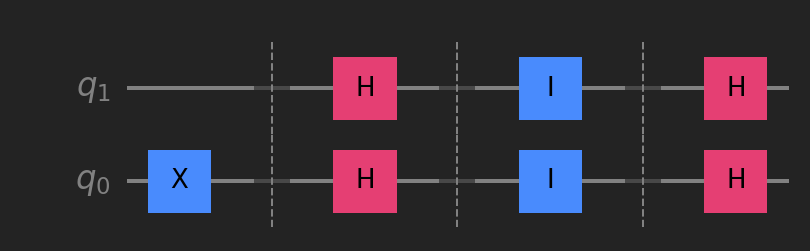

<IPython.core.display.Latex object>

In [10]:
# Circuit and output state for f(x) = 0
qc_fx_0 = QuantumCircuit(2)
qc_fx_0.x(0)
qc_fx_0.barrier()
qc_fx_0.h([1,0])
qc_fx_0.barrier()
qc_fx_0.id([1,0])
qc_fx_0.barrier()
qc_fx_0.h([1,0])
display(qc_fx_0.draw())
Statevector(qc_fx_0).draw('latex',prefix='|\\psi \\rangle_4 = ')

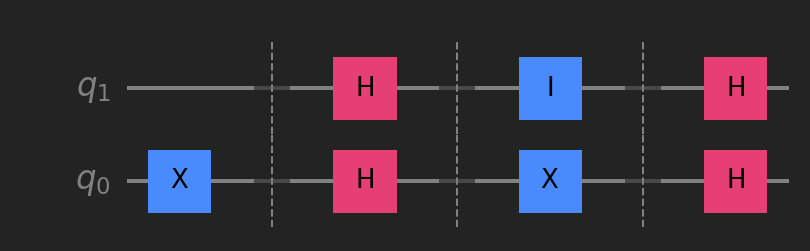

<IPython.core.display.Latex object>

In [11]:
# Circuit and output state for f(x) = 1
qc_fx_1 = QuantumCircuit(2)
qc_fx_1.x(0)
qc_fx_1.barrier()
qc_fx_1.h([1,0])
qc_fx_1.barrier()
qc_fx_1.x(0)
qc_fx_1.id(1)
qc_fx_1.barrier()
qc_fx_1.h([1,0])
display(qc_fx_1.draw())
Statevector(qc_fx_1).draw('latex',prefix='|\\psi \\rangle_4 = ')

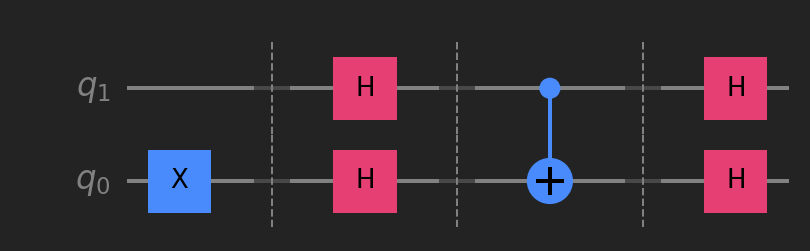

<IPython.core.display.Latex object>

In [12]:
# Circuit and output state for f(x) = x
qc_fx_x = QuantumCircuit(2)
qc_fx_x.x(0)
qc_fx_x.barrier()
qc_fx_x.h([1,0])
qc_fx_x.barrier()
qc_fx_x.cx(1,0)
qc_fx_x.barrier()
qc_fx_x.h([1,0])
display(qc_fx_x.draw())
Statevector(qc_fx_x).draw('latex',prefix='|\\psi \\rangle_4 = ')

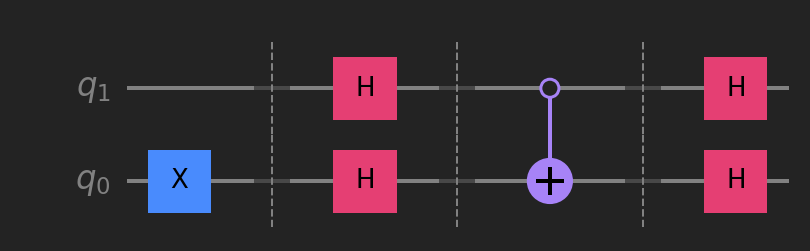

<IPython.core.display.Latex object>

In [13]:
# Circuit and output state for f(x) = x̅
qc_fx_x̅ = QuantumCircuit(2)
qc_fx_x̅.x(0)
qc_fx_x̅.barrier()
qc_fx_x̅.h([1,0])
qc_fx_x̅.barrier()
qc_fx_x̅.cx(1,0, ctrl_state='0')
qc_fx_x̅.barrier()
qc_fx_x̅.h([1,0])
display(qc_fx_x̅.draw())
Statevector(qc_fx_x̅).draw('latex',prefix='|\\psi \\rangle_4 = ')

## 2. Deutsch-Jozsa Algorithm

The Deutsch-Jozsa algorithm is the generalization of Deutsch's algorithm but where now the input $x$ to the function $f(x)$ is not a single bit, but a string of $n$ bits: $f: \{0, 1\}^n \longmapsto \{0, 1\}.$

The function $f(x)$ is **constant** if, regardless of the input string we always get the same output: either $f(x)$ is always $0$, or $f(x)$ is always $1$. For example, we can have a function $f: \{0, 1\}^2 \longmapsto \{0, 1\},$ such that:

$$
\begin{aligned}
f(00) &= 0
\\
f(01) &= 0
\\
f(10) &= 0
\\
f(11) &= 0
\end{aligned}
$$

On the other hand, $f(x)$ is **balanced** if for half of the inputs $f(x) = 0$, and for the other half $f(x) = 1$. For instance: 

$$
\begin{aligned}
f(00) &= 1
\\
f(01) &= 0
\\
f(10) &= 0
\\
f(11) &= 1
\end{aligned}
$$

As before, the function f(x) is encoded in a unitary $U_f$ (black box) that we can access as:

$$ |x\rangle \otimes \ |y\rangle \xrightarrow{\; U_f \;} |x\rangle \otimes |y \oplus f(x)\rangle, $$

but where the input $|x\rangle$ is an $n$-qubit state: 

<img src="images/04_01_09_black_box_mult.png" align = "center" width="340"/>

### 2.1 Deterministic Classical Approach

To find if the function $f(x)$ is constant or balanced classically, we would need to change the value of the input $x$ until we either get a different output (this would be an indication that the function is balanced), or evaluate $f(x)$ for at least half of the possible values $x$ can take. So, if $x$ is of length $n$ and we have gone over $2^n/2$ of the possible inputs without seeing $f(x)$ change, we know that if in the next try $f(x)$ doesn't change, the function is guaranteed to be constant. This because a balanced function is guaranteed to have an equal number of inputs that produce $f(x) = 0$ and $f(x) = 1$.

Therefore, whenever we are given a constant function, we will unescapably have to try more than half of the possible inputs (i.e., $2^n/2 + 1$ tries). If the function is balanced and get lucky, we will need to evaluate $f(x)$ for at least $2$ values of $x$.

Let's create a function that generates a **constant** or an unstructured **balanced** black box, and simulate the numbers of tries it takes to guess correctly which type of function we have.

In [14]:
import matplotlib.pyplot as plt

In [15]:
# Function that generates at random a constant or a balanced function for an n-qubit input.
def black_box_n(n):
    bb_type = np.random.randint(2) # bb_type = 0 for constant, bb_type = 1 for balanced
    
    qc_bb = QuantumCircuit(n+1, name='Black Box')
    
    if bb_type:
        # Generate random list of x values that evaluate to f(x) = 1
        x_list = np.random.choice(2**n, size=2**n//2, replace=False)
        
        for x in x_list:
            qc_bb.mcx(list(range(1,n+1)),0, ctrl_state=np.binary_repr(x,n))
            
    return qc_bb, bb_type

In [16]:
# Simulate k runs of finding if f(x) is const or bal

k = 100                          # Number of runs to play the game
n = 4                            # Length of x (number of qubits)
N = 2**n                         # Number of possible values x can take
tries_lst = [0]*(N//2+2)         # List to track number of guesses

simulator = AerSimulator()       # define simulator object

for i in range(k):
    bb, bb_type = black_box_n(n)

    fx_unknwn = True             # Is the type of still function unknown?
    tries = 0                    # Number of tries to guess if f(x) const or bal
    
    # Try different inputs until finding if function is balanced or reaching half of possible inputs
    while (fx_unknwn) and (tries < N//2+1):
        
        qc = QuantumCircuit(n+1,1)
        qc.prepare_state(tries,range(1,n+1))
        qc.append(bb,range(n+1))
        qc.measure(0,0)
        
        qc_t = transpile(qc, simulator)
        job = simulator.run(qc_t, shots=1, memory=True)  # Run one simulation per black box 

        if tries == 0:
            first_fx = job.result().get_memory()[0]      # extract output value of f(x)
        else:
            fx = job.result().get_memory()[0]
            if fx != first_fx:                           # Check if f(x) changed
                fx_unknwn = False                
        tries += 1

    tries_lst[tries] += 1
    
percentage_lst = [100*trie/k for trie in tries_lst]   # List with percentage of runs for a given number of tries

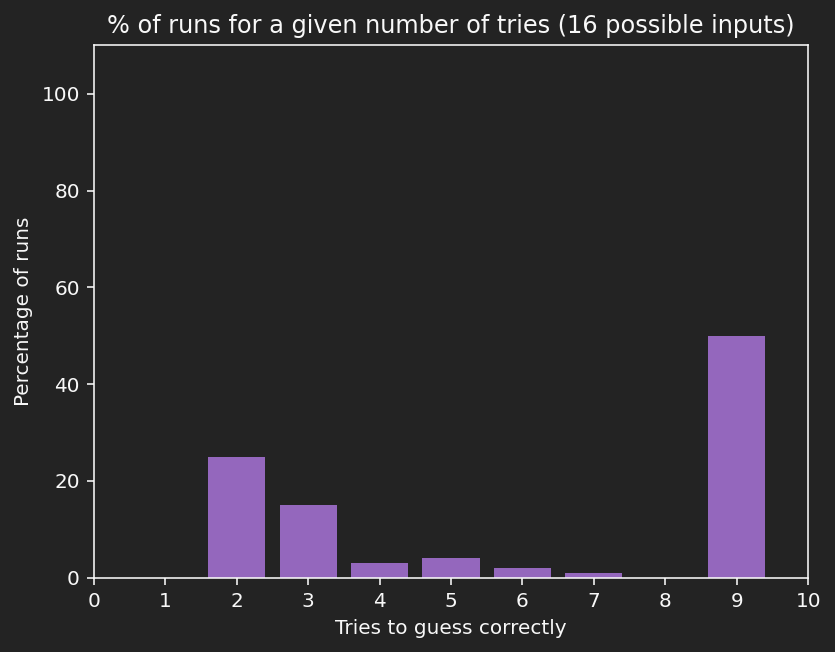

In [17]:
# Plot number of tries to guess correctly if function is const or bal
plt.bar(range(1, N//2+2), percentage_lst[1:], color='tab:purple')
plt.title(f'% of runs for a given number of tries ({N} possible inputs)')
plt.xlabel('Tries to guess correctly')
plt.ylabel('Percentage of runs')
plt.xlim(0, N//2+2)
plt.xticks(range(0, N//2+3, 1))
plt.ylim(0, 110)
plt.show()

As can be seen, about $50\%$ of the time we will have to try $2**n/2 + 1$ different inputs before we can predict with certainty if the function is constant or balanced. This is because roughly half of the time we are given a constant function, which requires verifying at least half of the input strings. For the cases in which we are given a balanced function, we can guess it correctly mostly with only 2 tries. 

### 2.2 Quantum Approach

Unlike the classical strategy, Deutsch-Jozsa algorithm guarantees finding if a function is constant or balanced in only one try. 

The circuit implementation is identical to that of Deutsch's algorithm, but where we place the input state in a superposition (by applying the [Quantum Hadamard Transform](https://learnquantum.io/chapters/02_quantum_computing/02_05_quantum_blocks.html#the-quantum-hadamard-transform) to the whole state), and perform interference on it after accessing the function $U_f:$

<img src="images/04_01_10_deutsch-jozsa.png" align = "center" width="520"/>

Let's analyze the circuit step by step:

0. Initialize the all-zeros state: $|\psi\rangle_0 = |0\rangle^{\otimes n} \otimes |0\rangle$
1. Apply $X$ gate to bottom qubit $|p\rangle$: $|\psi\rangle_1 = |0\rangle^{\otimes n} \otimes |1\rangle$
2. Apply $H$ gate to $|p\rangle$ and $\text{QHT}$ to $|q\rangle$: $|\psi\rangle_2 = \text{QHT}_n |0\rangle^{\otimes n} \otimes H |1\rangle$

This places the input state $|q\rangle$ in an equal superposition over all possible values of $x$, and $|p\rangle$ in the minus state:

$$
|\psi\rangle_2 = \left( \frac{1}{\sqrt{N}} \sum_{x = 0}^{N - 1} |x\rangle \right) \otimes |-\rangle,
$$

where $N = 2^n .$

3. Evolve the state through $U_f$:

$$
|\psi\rangle_3 = \left( \frac{1}{\sqrt{N}} \sum_{x = 0}^{N - 1} (-1)^{f(x)} |x\rangle \right) \otimes |-\rangle
$$

The result above is obtained by recalling that for each value of $|x\rangle$ we have: 

$$ |x\rangle \otimes |-\rangle \xrightarrow{\; Uf \;} (-1)^{f(x)}|x\rangle \otimes |-\rangle, $$

which, by linearity, can be applied to each of the $|x\rangle$ terms in the superposition.

Here, we can make the observation that, if our function $f(x)$ is constant (i.e. $f(x) = 0$ or $f(x) = 1$ for all values of $x$), the prefactors $(-1)^{f(x)}$ in the superposition are all the same value independent of $x$, so we can pullout them out of the summation as a global phase:

$$
|\psi\rangle_3 = (-1)^{f(x)} \left(\frac{1}{\sqrt{N}} \sum_{x = 0}^{N - 1}  |x\rangle \right) \otimes |-\rangle, \; \text{when} \; f(x) \; \text{is constant} .
$$

It is also convenient to point out that the term inside the parenthesis is nothing other than the equal superposition state, which results from applying the $\text{QHT}$ to the all-zeros state. So we can express the state above as:

$$
|\psi\rangle_3 = (-1)^{f(x)} \big(\text{QHT}_n|0\rangle^{\otimes n} \big) \otimes |-\rangle, \; \text{when} \; f(x) \; \text{is constant} .
$$

Alternatively, when $f(x)$ is balanced, we know that half of the terms in the summation have coefficients where the exponent is $f(x) = 0$. Similarly, the other half have an exponent where $f(x) = 1$. Therefore, half of the terms will have positive probability amplitudes $((-1)^0 = 1)$, and the other half will be negative $((-1)^1 = -1)$. We can then rewrite $|\psi\rangle_3$ as:

$$
|\psi\rangle_3 = \frac{1}{\sqrt{N}} \Bigg ( \underbrace{ \sum_{x | f(x) = 0}  |x\rangle }_{N/2 \text{ terms}}  - \underbrace{ \sum_{x | f(x) = 1}  |x\rangle }_{N/2 \text{ terms}} \Bigg ) \otimes |-\rangle, \; \text{when} \; f(x) \; \text{is balanced} .
$$

4. Now, we can analyze for the two different cases the result of applying an $H$ gate to the bottom qubit $|p\rangle$, and the $\text{QHT}$ to $|q\rangle$: $|\psi\rangle_4 = (\text{QHT}_n \otimes H) |\psi\rangle_3$

- For the case where the function is constant:

$$
\begin{aligned}
|\psi\rangle_4 &= (-1)^{f(x)} \text{QHT}_n \big(\text{QHT}_n|0\rangle^{\otimes n} \big) \otimes H |-\rangle
\\
\\
|\psi\rangle_4 &= (-1)^{f(x)} |0\rangle^{\otimes n} \otimes |1\rangle
\\
\\
|\psi\rangle_4 &= |0\rangle^{\otimes n} \otimes |1\rangle, \; \text{(up to a global phase) when} \; f(x) \; \text{is constant} .
\end{aligned}
$$

The result above stems from the fact that applying the $\text{QHT}$ twice results in an identity operation. Therefore, we always end up with the all-zeros state $|0\rangle^{\otimes n}$ in the top qubits $|q\rangle$ when the functions is constant (up to a global phase of $(-1)^{f(x)}.$)

- Now, for the case where the function is balanced, what we need to realize is that, for any arbitrary basis state $|x\rangle, $ the $\text{QHT}$ is a state of the form:

$$ \text{QHT}_n |x\rangle = \frac{1}{\sqrt{N}} \sum_{z = 0}^{N - 1} (-1)^{x \cdot z} |z\rangle .$$

In other words, irrespective of the value of $|x\rangle$, we always end up with an equal superposition of all basis states, where each coefficient is either $1$ or $-1$ depending on the inner product $x \cdot z .$ The main insight here is to realize that, the first element of this superposition is always the all-zeros state $|0\rangle^{\otimes n}$, which always has a coefficient of one: $(-1)^{x \cdot 0} = 1 .$ Therefore, we can always rewrite the state above as:

$$ \text{QHT}_n |x\rangle = \frac{1}{\sqrt{N}} \left(|0\rangle^{\otimes n} + \sum_{z = 1}^{N - 1} (-1)^{x \cdot z} |z\rangle \right ).$$

With this, we can find the final state for a balanced function as:

$$
\begin{aligned}
|\psi\rangle_4 &= (\text{QHT}_n \otimes H) |\psi\rangle_3
\\
\\
|\psi\rangle_4 &= \text{QHT}_n \frac{1}{\sqrt{N}} \Bigg ( \sum_{x | f(x) = 0}  |x\rangle - \sum_{x | f(x) = 1}  |x\rangle \Bigg ) \otimes H |-\rangle
\\
\\
|\psi\rangle_4 &= \frac{1}{\sqrt{N}} \left ( \sum_{x | f(x) = 0} \text{QHT}_n |x\rangle - \sum_{x | f(x) = 1}  \text{QHT}_n |x\rangle \right ) \otimes |1\rangle
\\
\\
|\psi\rangle_4 &= \frac{1}{\sqrt{N}} \left [ \sum_{x | f(x) = 0} \frac{1}{\sqrt{N}} \left(|0\rangle^{\otimes n} + \sum_{z = 1}^{N - 1} (-1)^{x \cdot z} |z\rangle \right ) - \sum_{x | f(x) = 1}  \frac{1}{\sqrt{N}} \left(|0\rangle^{\otimes n} + \sum_{z = 1}^{N - 1} (-1)^{x \cdot z} |z\rangle \right )\right ] \otimes |1\rangle
\\
\\
|\psi\rangle_4 &= \frac{1}{N} \left [ \sum_{x | f(x) = 0} \left(|0\rangle^{\otimes n} + \sum_{z = 1}^{N - 1} (-1)^{x \cdot z} |z\rangle \right ) - \sum_{x | f(x) = 1} \left(|0\rangle^{\otimes n} + \sum_{z = 1}^{N - 1} (-1)^{x \cdot z} |z\rangle \right )\right ] \otimes |1\rangle
\\
\\
|\psi\rangle_4 &= \frac{1}{N} \left [ \underbrace{\frac{N}{2}|0\rangle^{\otimes n}}_{\text{all-zeros state}} + \sum_{x | f(x) = 0} \sum_{z = 1}^{N - 1} (-1)^{x \cdot z} |z\rangle - \underbrace{\frac{N}{2}|0\rangle^{\otimes n}}_{\text{all-zeros state}} - \sum_{x | f(x) = 1} \sum_{z = 1}^{N - 1} (-1)^{x \cdot z} |z\rangle \right ] \otimes |1\rangle
\\
\\
|\psi\rangle_4 &= \frac{1}{N} \left [ \sum_{x | f(x) = 0} \sum_{z = 1}^{N - 1} (-1)^{x \cdot z} |z\rangle - \sum_{x | f(x) = 1} \sum_{z = 1}^{N - 1} (-1)^{x \cdot z} |z\rangle \right ] \otimes |1\rangle
\\
\\
|\psi\rangle_4 &= \left ( \frac{1}{N} \sum_{x = 0}^{N - 1} \sum_{z = 1}^{N - 1} (-1)^{f(x)} (-1)^{x \cdot z} |z\rangle \right ) \otimes |1\rangle, \; \text{when} \; f(x) \; \text{is balanced}.
\end{aligned}
$$

Notice how the all-zeros states cancel out due to the equal number of positive terms coming out of the $f(x) = 0$ summation, and negative terms from the $f(x) = 1$ summation. We can the rewrite the output state above as:

$$ |\psi\rangle_4 = |Ø \rangle \otimes |1\rangle, \; \text{where} \; \langle Ø | 0\rangle^{\otimes n} = 0.$$

In other words, the top qubits end up in a state $|Ø \rangle$ that is guaranteed to **NOT** contain the all-zeros state.

So, in summary, we have two possible output states:

$$
\begin{split} |\psi \rangle_4 = 
\begin{cases}
    |0\rangle^{\otimes n} \otimes |1\rangle & \text{if } f(x) \; \text{is constant},
    \\
    \\
    |Ø \rangle \otimes |1\rangle & \text{if } f(x) \; \text{is balanced} .
\end{cases}
\end{split}
$$

This implies that, if we measure state $|q\rangle$ and get the all-zeros state, we know $U_f$ is constant. On the other hand, if we measure $|q\rangle$ and get anything other than the all-zeros state, we know $U_f$ is balanced.

Let's now implement the Deutsch-Jozsa algorithm in qiskit, and simulate the number of tries it takes to correctly predict if $f(x)$ is constant or balanced.

In [18]:
def deutsch_josza(n):
    bb, bb_type = black_box_n(n)              # generate random black-box of n input qubits
    
    qc_dj = QuantumCircuit(n+1,n)
    qc_dj.x(0)                                # Initialize bottom qubit to |1〉
    qc_dj.barrier()
    qc_dj.h(range(n+1))                       # Hadamard gates on all qubits
    qc_dj.append(bb,range(n+1))               # append black box to circuit
    qc_dj.h(range(n+1))                       # Hadamard gates on all qubits
    qc_dj.measure(range(1,n+1),range(n))      # measure top n qubits
    
    return qc_dj, bb_type

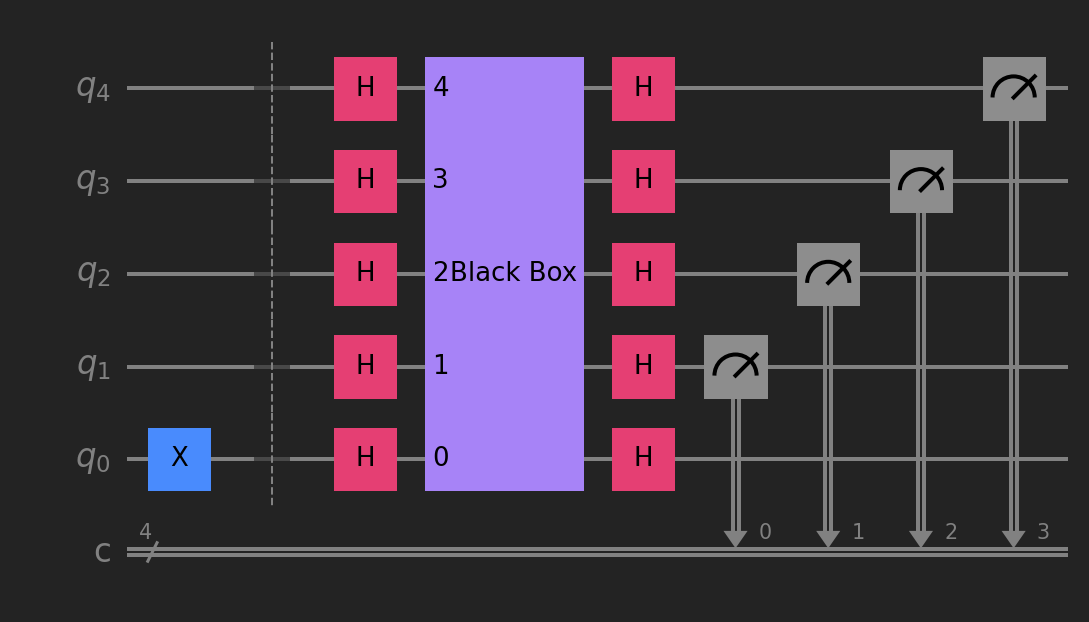

In [19]:
# Draw example of Deutsch-Jozsa circuit for 4 qubits
qc = deutsch_josza(4)[0]
qc.draw()

In [20]:
# Simulate k runs of finding if f(x) is const or bal using D-J algorithm

k = 100                          # Number of times to play the game
n = 4                            # Length of x (number of qubits)
N = 2**n                         # Number of possible values x can take
tries_lst = [0]*(N//2+2)         # List to track number of guesses

for i in range(k):
    qc, bb_type = deutsch_josza(n)
    
    fx_unknwn = True             # Is the type of function still unknown?
    tries = 0                    # Number of tries to guess if f(x) const or bal
    
    while (fx_unknwn) and (tries < N//2+1):
        
        qc_t = transpile(qc, simulator)
        job = simulator.run(qc_t, shots=1, memory=True)  # Run one simulation per black box 
        outcome = job.result().get_memory()[0]
        
        # check if outcome is the all-zeros state AND the function is constant
        if int(outcome) == 0 and (not bb_type):
            tries_lst[tries] += 1
            fx_unknwn = False
        
        # check if outcome is not the all-zeros state AND the function is balanced
        if int(outcome) != 0 and (bb_type):
            tries_lst[tries] += 1
            fx_unknwn = False
            
        tries += 1

    tries_lst[tries] += 1
    
percentage_lst = [100*trie/k for trie in tries_lst]   # List with percentage of runs for a given number of tries

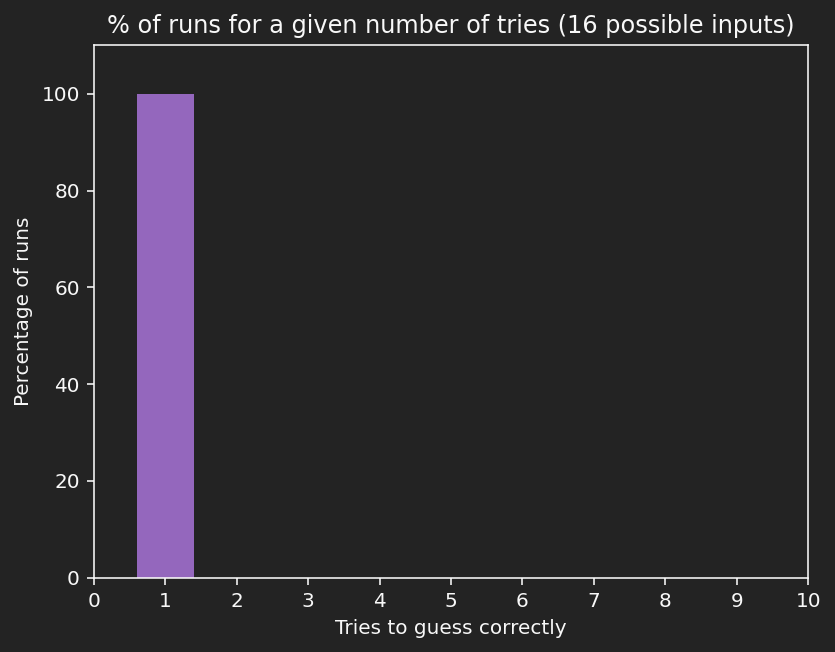

In [21]:
# Plot number of tries to guess correctly if function is const or bal
plt.bar(range(1, N//2+2), percentage_lst[1:], color='tab:purple')
plt.title(f'% of runs for a given number of tries ({N} possible inputs)')
plt.xlabel('Tries to guess correctly')
plt.ylabel('Percentage of runs')
plt.xlim(0, N//2+2)
plt.xticks(range(0, N//2+3, 1))
plt.ylim(0, 110)
plt.show()

As can be seen, using the Deutsch-Jozsa algorithm we can find with certainty if we have a constant or a balanced function in one one try.

### 2.3 Comments on Black Box Implementation

In the previous sections, we assumed a black box that encodes the unitary for a constant or balanced function was given to us. Here we provide some details on how these are implemented and run a few simulations showing the input to output relation.

In [22]:
# Function to print |x⟩|y⟩→|x⟩|y⊕f(x)⟩ for all combinations of |x⟩
def print_func_eval(n, y, qc):
    from IPython.display import Math
    
    pre_in = '|x\\rangle \\otimes |y \\rangle'
    pre_out = '|x\\rangle \\otimes |y \\oplus f(x) \\rangle'
    display(Math(pre_in+'\\xrightarrow{\\; U_f \\;}'+pre_out))
    
    for i in range(2**n):
        x = Statevector.from_label(np.binary_repr(i,n))
        in_str = x.draw('latex_source')+'\\otimes'+y.draw('latex_source')

        ψ_in = x.tensor(y)
        ψ_out = ψ_in.evolve(qc)
        out_str = ψ_out.draw('latex_source')[1:n+2]+'\\rangle \\otimes |'+ψ_out.draw('latex_source')[n+2:]

        display(Math(in_str+'\\longrightarrow'+out_str))

Implementing a constant function is very simple. Similar to Deutsch's algorithm, all we need to do is either leave the bottom qubit unchanged for $f(x) = 0$, or apply an $X$ gate for $f(x) = 1$. This guarantees the output state $|f(x)\rangle$ to always give the same output regardless of what input value of $x$ we have:

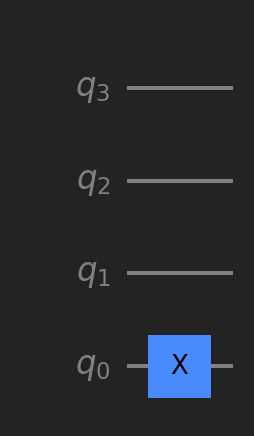

In [23]:
# Implementation of constant f(x)

n = 3           # Number of input qubits
fx = 1          # set constant value to fx = 0 or fx = 1

qc_const = QuantumCircuit(n+1, name='f(x) const')
qc_const.x(0)
qc_const.draw()

In [24]:
# Evaluate constant f(x) for all possible |x⟩ inputs with |y⟩=|0⟩:
y = Statevector.from_label('0')
print_func_eval(n, y, qc_const)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

As can be seen, the output qubit always returns $|1\rangle$, irrespective of the value of $|x\rangle.$ If you want, run the Deutsch-Jozsa algorithm on using this function to verify that you always get the all-zeros state at the output.

Now, there are many different ways in which we can implement a balanced function. For example, we can implement a circuit where the $f(x)$ is the [parity bit](https://en.wikipedia.org/wiki/Parity_bit) of the input $x$ (i.e., $f(x) = 0$ if $x$ has an even number of ones, and $f(x) = 1$ if $x$ has an odd number of ones):

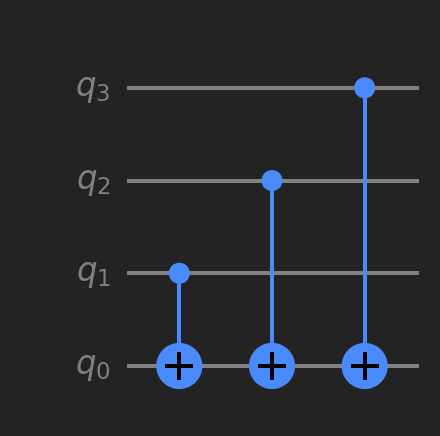

In [25]:
# Implementation of parity function (balanced f(x))

n = 3           # Number of input qubits

qc_parity = QuantumCircuit(n+1, name='f(x) parity')
for i in range(1,n+1):
    qc_parity.cx(i,0)
qc_parity.draw()

In [26]:
# Evaluate parity f(x) for all possible |x⟩ inputs with |y⟩=|0⟩:
y = Statevector.from_label('0')
print_func_eval(n, y, qc_parity)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

We can run the Deutsch-Jozsa algorithm with this balance function to verify that we indeed never get the all-zeros string at the output.

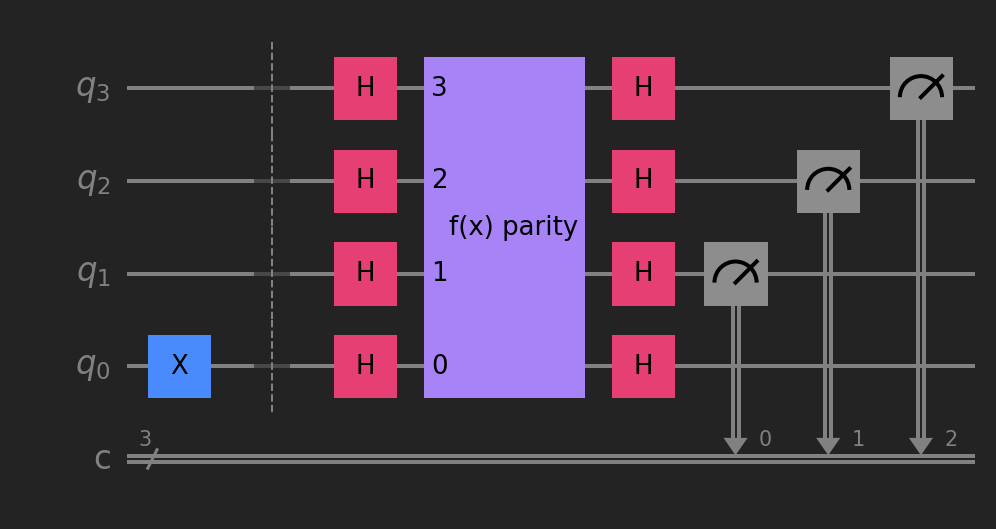

In [27]:
qc_dj_parity = QuantumCircuit(n+1,n)
qc_dj_parity.x(0)                                # Initialize bottom qubit to |1〉
qc_dj_parity.barrier()
qc_dj_parity.h(range(n+1))                       # Hadamard gates on all qubits
qc_dj_parity.append(qc_parity,range(n+1))        # append parity circuit
qc_dj_parity.h(range(n+1))                       # Hadamard gates on all qubits
qc_dj_parity.measure(range(1,n+1),range(n))      # measure top n qubits

qc_dj_parity.draw()

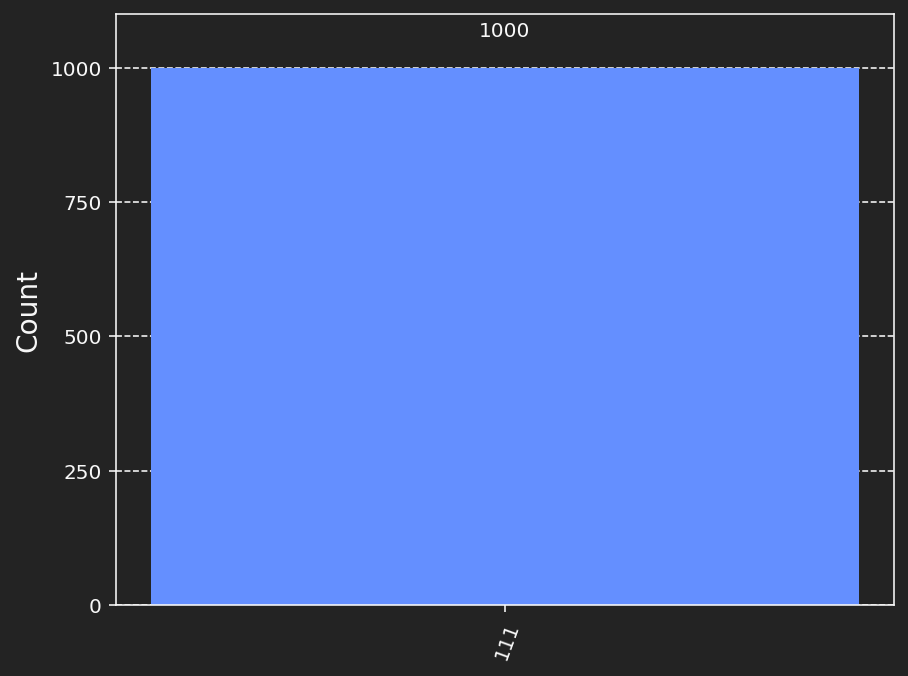

In [28]:
qc_t = transpile(qc_dj_parity, simulator)
job = simulator.run(qc_t, shots=1000)  # Run simulation for 1000 shots
counts = job.result().get_counts()

plot_histogram(counts)

As can be seen, for the parity function, we always get the all-ones state $|1\rangle^{\otimes}$ at the output.

Another balanced function would be the one where the first $N/2$ possible values of $x$ always produce $f(x) = 0$, and the remaining $N/2+1$ through $N$ always produce $f(x) = 1$ (or vice-versa):

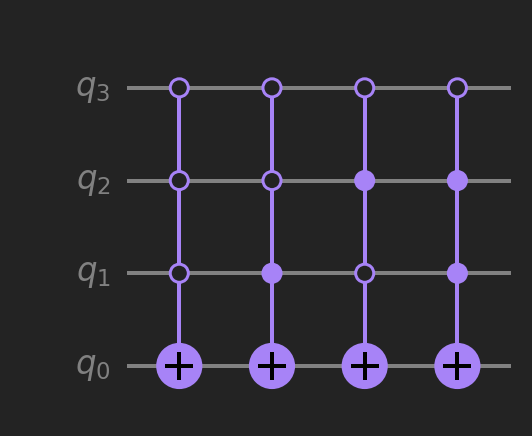

In [29]:
# Implementation of function where first half inputs produce f(x) = 1 (or 0) 
# and the other half produce f(x) = 0 (or 0) (balanced f(x))

n = 3           # Number of input qubits
N = 2**n        # Number of possible inputs
hx = 0          # hx = 0 produces f(x) = 1 for first half of possible inputs
                # hx = 1 produces f(x) = 1 for second half of possible inputs

qc_split = QuantumCircuit(n+1, name='f(x) split')

for i in range(hx*(N//2), (hx+1)*(N//2)):
    qc_split.mcx(list(range(1,n+1)),0, ctrl_state=np.binary_repr(i,n))

qc_split.draw()

In [30]:
# Evaluate parity f(x) for all possible |x⟩ inputs with |y⟩=|0⟩:
y = Statevector.from_label('0')
print_func_eval(n, y, qc_split)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Again, we can run the Deutsch-Jozsa algorithm on this balanced function to see we never get the all-zeros string:

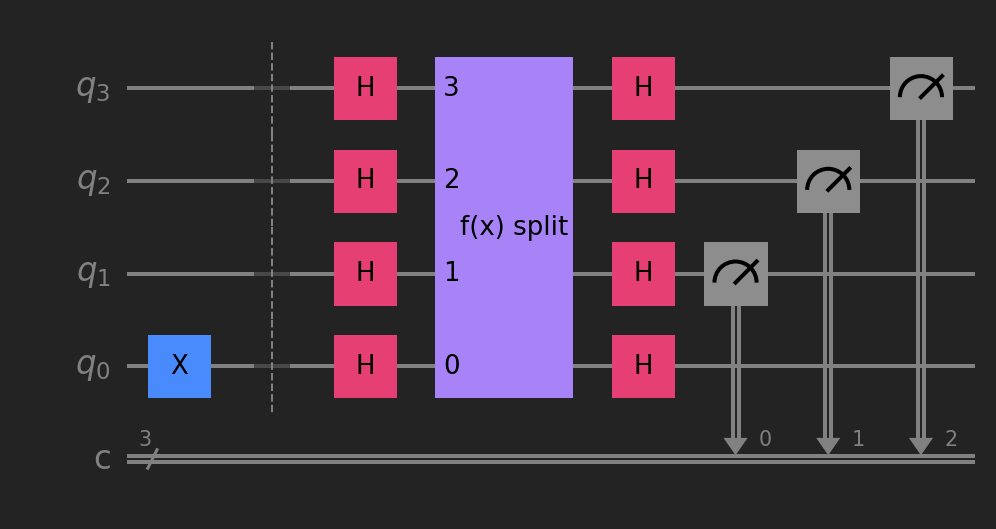

In [31]:
qc_dj_split = QuantumCircuit(n+1,n)
qc_dj_split.x(0)                                # Initialize bottom qubit to |1〉
qc_dj_split.barrier()
qc_dj_split.h(range(n+1))                       # Hadamard gates on all qubits
qc_dj_split.append(qc_split,range(n+1))         # append split circuit
qc_dj_split.h(range(n+1))                       # Hadamard gates on all qubits
qc_dj_split.measure(range(1,n+1),range(n))      # measure top n qubits

qc_dj_split.draw()

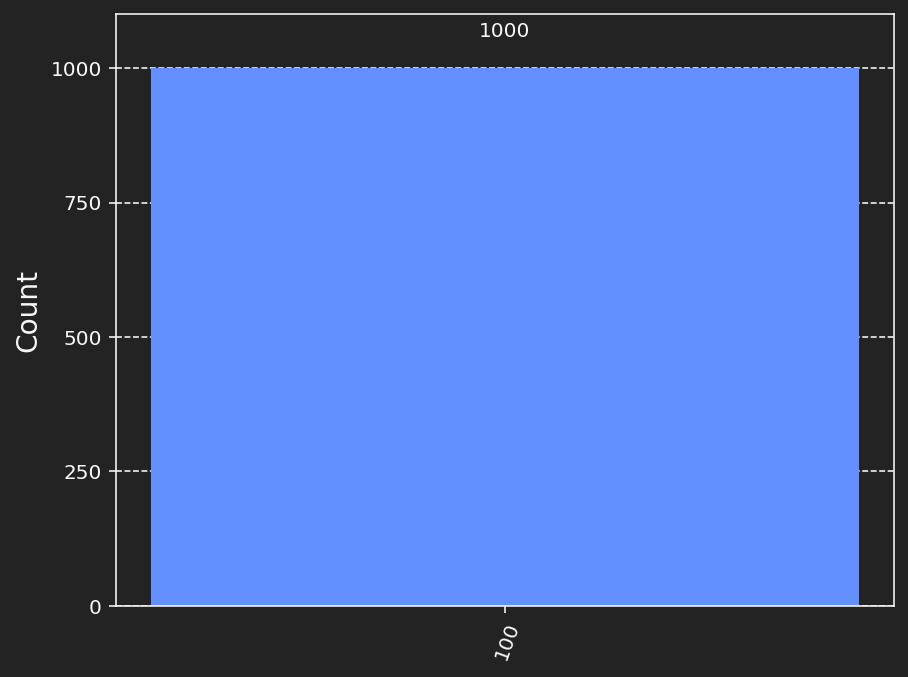

In [32]:
qc_t = transpile(qc_dj_split, simulator)
job = simulator.run(qc_t, shots=1000)  # Run simulation for 1000 shots
counts = job.result().get_counts()

plot_histogram(counts)

Change the value of `hx` above to `1` and try to explain the results.

Lastly, we can generalize the implementation above so that we randomly select an equal number of values of $x$ that result in $f(x) = 0$ and $f(x) = 1$. This was the black box implementation we used in sections 2.1 and 2.2.

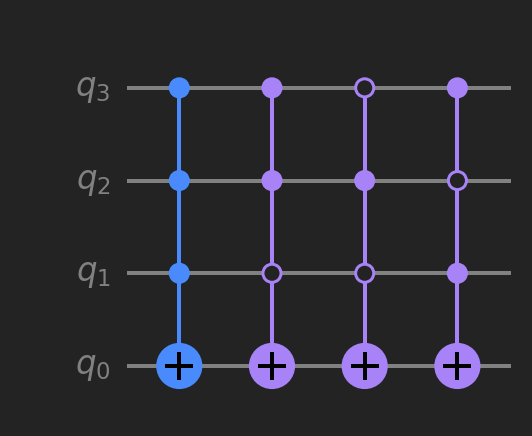

In [33]:
# Implementation of function that randomly selects x values for f(x) = 0 and f(x) = 1 (balanced f(x))

n = 3           # Number of input qubits
N = 2**n        # Number of possible inputs

x_list = np.random.choice(2**n, size=N//2, replace=False)

qc_unstrct = QuantumCircuit(n+1, name='f(x) unstruct')

for x in x_list:
    qc_unstrct.mcx(list(range(1,n+1)),0, ctrl_state=np.binary_repr(x,n))

qc_unstrct.draw()

In [34]:
# Evaluate parity f(x) for all possible |x⟩ inputs with |y⟩=|0⟩:
y = Statevector.from_label('0')
print_func_eval(n, y, qc_unstrct)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

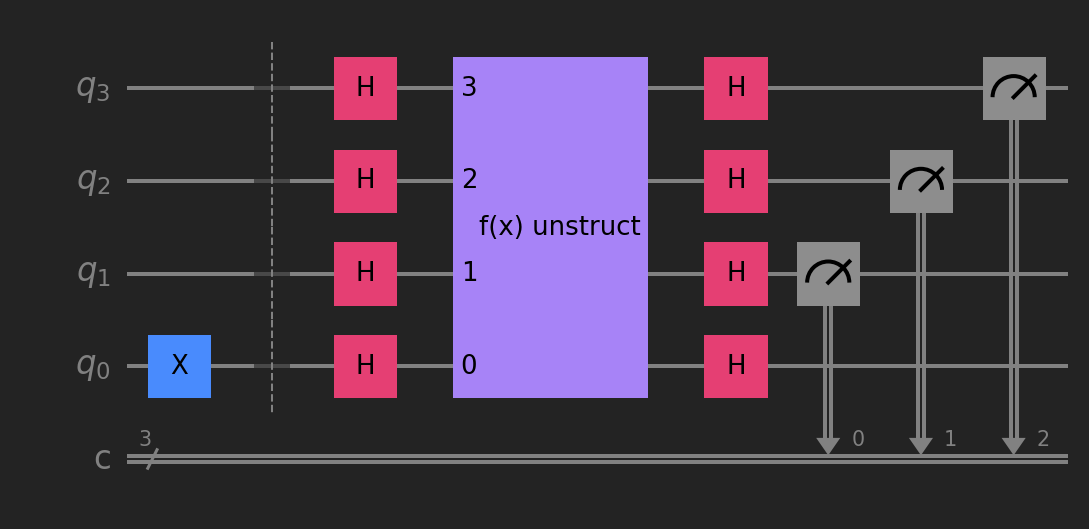

In [35]:
qc_dj_unstrct= QuantumCircuit(n+1,n)
qc_dj_unstrct.x(0)                                # Initialize bottom qubit to |1〉
qc_dj_unstrct.barrier()
qc_dj_unstrct.h(range(n+1))                       # Hadamard gates on all qubits
qc_dj_unstrct.append(qc_unstrct,range(n+1))         # append unstructured circuit
qc_dj_unstrct.h(range(n+1))                       # Hadamard gates on all qubits
qc_dj_unstrct.measure(range(1,n+1),range(n))      # measure top n qubits

qc_dj_unstrct.draw()

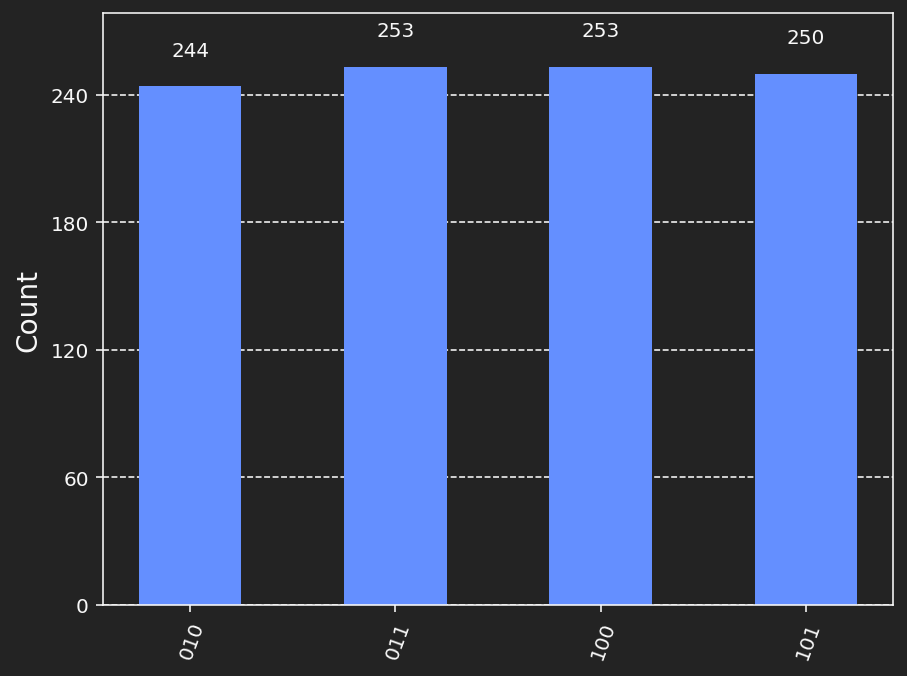

In [36]:
qc_t = transpile(qc_dj_unstrct, simulator)
job = simulator.run(qc_t, shots=1000)  # Run simulation for 1000 shots
counts = job.result().get_counts()

plot_histogram(counts)

Again, it can be seen that, even though it is now possible to get a superposition state of multiple values, we never get the all-zeros string at the output.